# APERO Demos

The aim of these demos is to walk you through some of the key steps in the
data reduction using APERO.

## Prerequisites for exercises

- Python 3.9  (e.g. via [conda](https://docs.conda.io/en/latest/miniconda.html))
    ```
    conda create --name=apero-demo python=3.9
    conda activate apero-demo
    pip install -r requirements.txt
    ```


- DS9 ([download](https://sites.google.com/cfa.harvard.edu/saoimageds9))


- dfits and fitsort
  - python implementation: [download](https://astrom-tom.github.io/dfitspy/build/html/installation.html)
  - C implmentation: [download](https://github.com/granttremblay/eso_fits_tools)


- Download the file bundle: [download](https://www.astro.umontreal.ca/~artigau/apero_demo/apero_nirps_demo.tar)


## Exercise 2: Looking at detector cosmetics

- Step 1: Find the DARK_FP RAMP file
- Step 2: In python remove horizontal striping
- Step 3: In python remove the “butterfly” pattern

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

In [20]:
# notebook only
%matplotlib inline

In [21]:
# DARK+FP file
file = 'NIRPS_2023-02-06T12_54_00_118.fits'

In [22]:
# read the image
im = fits.getdata(file)

In [23]:
# find illuminated pixels
bright_pix = im > np.nanpercentile(im, 95)

# dummy image with pixels that are illuminated as NaNs
dark_pix = np.array(im)
dark_pix[bright_pix] = np.nan

# median structure along y axis
med = np.nanmedian(dark_pix, axis=1)

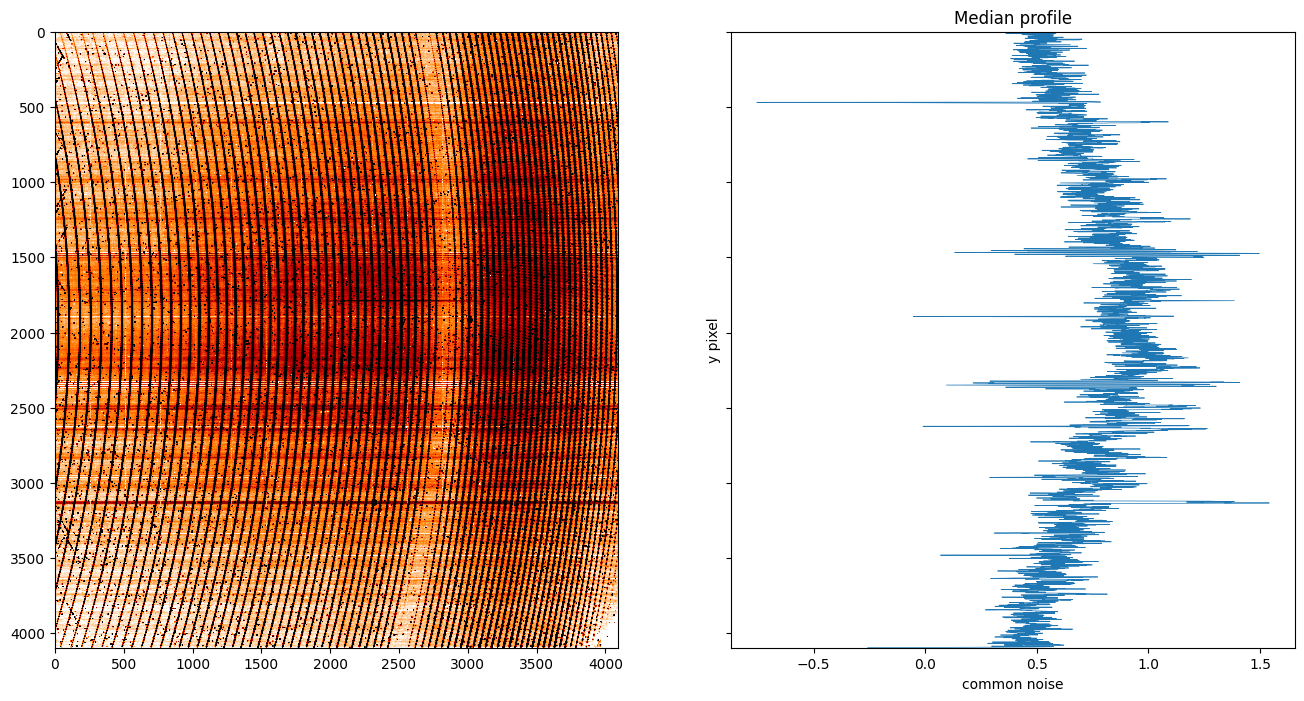

In [24]:
# plot the the horizontal striping
fig, ax = plt.subplots(nrows=1, ncols=2, sharey='all', figsize=(16, 8))
vmin, vmax = np.nanpercentile(im, [10, 85])
ax[0].imshow(im, vmin=vmin, vmax=vmax, aspect='auto', cmap='gist_heat_r')
ax[1].plot(med, np.arange(len(med)), lw=0.5)
ax[1].set(ylabel='y pixel', xlabel='common noise', title='Median profile')
plt.show()

In [25]:
# replicate into 2d array and subtract
im -= np.repeat(med, im.shape[1]).reshape(im.shape)
# do the same on the dummy image with flux masked
dark_pix -= np.repeat(med, im.shape[1]).reshape(im.shape)
fits.writeto('correction1.fits', im, overwrite=True)
# save the image that has been masked
fits.writeto('correction1_dark_pix.fits', dark_pix, overwrite=True)


In [26]:
# cube that will contain individual amplifiers flipped along the readout
# direction
cube_amps = np.zeros([32, 4096, 128])
for iamp in range(32):
    amp = dark_pix[:, iamp * 128:iamp * 128 + 128]
    if (iamp % 2) == 1:
        # swap for the butterfly pattern
        amp = np.array(amp[:, ::-1])
    cube_amps[iamp] = amp

med_amp = np.nanmedian(cube_amps, axis=0)

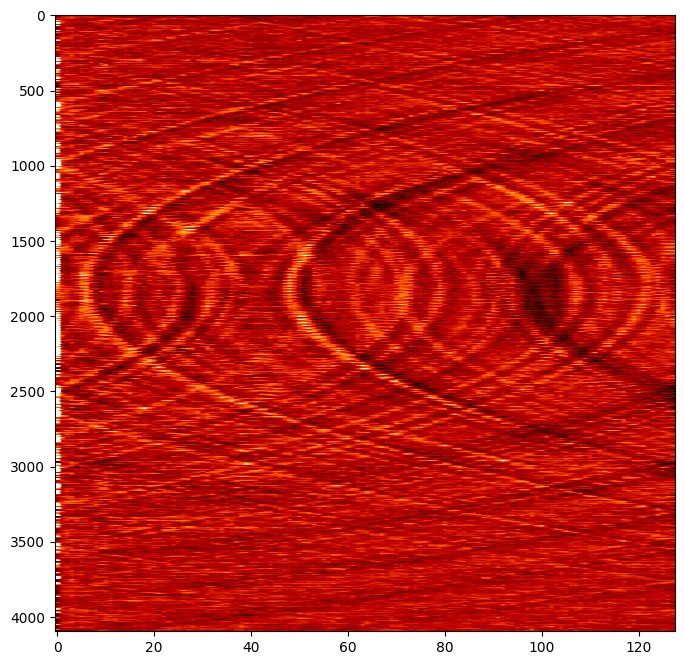

In [27]:
# show the butterfly image
vmin, vmax = np.nanpercentile(med_amp, [1, 99])
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(med_amp, aspect='auto', vmin=vmin, vmax=vmax, cmap='gist_heat_r')
plt.show()

In [28]:
# push the median amplifier values into the butterfly image
butterfly = np.zeros_like(im)
for iamp in range(32):
    if (iamp % 2) == 0:
        butterfly[:, iamp * 128:iamp * 128 + 128] = med_amp
    else:
        butterfly[:, iamp * 128:iamp * 128 + 128] = med_amp[:, ::-1]

In [29]:
# write to file to look at in ds9
fits.writeto('correction2.fits', im - butterfly, overwrite=True)
fits.writeto('butterfly.fits', butterfly, overwrite=True)
